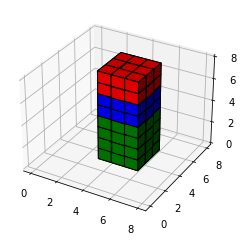

In [1]:
from artefact_nca.dataset.voxel_dataset import VoxelDataset
from artefact_nca.model.voxel_ca_model import VoxelCAModel
from artefact_nca.trainer.voxel_ca_trainer import VoxelCATrainer


import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# prepare some coordinates
x, y, z = np.indices((8, 8, 8))

# draw cuboids in the top left and bottom right corners, and a link between them
cube1 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z < 4)
cube2 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z >= 4) & (z < 6)
cube3 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z >= 6) & (z < 8) 

# link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxels = cube1 | cube2 | cube3

# set the colors of each object
colors = np.empty(voxels.shape, dtype=object)
colors[cube3] = 'red'
colors[cube1] = 'green'
colors[cube2] = 'blue'

# and plot everything
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(colors, facecolors=colors, edgecolor='k')

plt.show()

from artefact_nca.utils.minecraft.voxel_utils import voxel_to_numeric

voxel, target_unique_val_dict = voxel_to_numeric(colors)


In [2]:
import attr
import torch.nn.functional as F
import torch
import numpy as np
from einops import rearrange

@attr.s
class CustomMSETrainer(VoxelCATrainer):


    def get_fitness(self, grown_robot):
        return 0
    
    def custom_seed(self, batch_size):
        depth = self.dataset.depth
        height = self.dataset.height
        width = self.dataset.width
        
        seed = np.ones(
                    (batch_size, depth, height, width, self.num_channels)
                ) * 10
        return torch.from_numpy(seed).float().to(self.device)
    
    def train_func(self, x, targets, steps=1):
        self.optimizer.zero_grad()
        x = self.model(x, steps=steps, rearrange_output=False)
        fitness = self.get_fitness(x)
    
        loss, iou_loss = self.get_loss(x, targets)

        loss.backward()
        self.optimizer.step()
        self.scheduler.step()
        x = rearrange(x, "b c d h w -> b d h w c")
        out = {
            "out": x,
            "metrics": {"loss": loss.item(), "iou_loss": iou_loss.item()},
            "loss": loss,
        }
        return out

    def train_iter(self, batch_size=32, iteration=0):
        batch, targets, indices = self.sample_batch(batch_size)
        batch = self.custom_seed(batch_size)
        if self.use_sample_pool:
            with torch.no_grad():
                loss_rank = (
                    self.rank_loss_function(batch, targets)
                    .detach()
                    .cpu()
                    .numpy()
                    .argsort()[::-1]
                )
                batch = batch[loss_rank.copy()]
                batch[:1] = torch.from_numpy(self.get_seed()).to(self.device)

                if self.damage:
                    self.apply_damage(batch)

        steps = np.random.randint(self.min_steps, self.max_steps)
        if self.half_precision:
            with torch.cuda.amp.autocast():
                out_dict = self.train_func(batch, targets, steps)
        else:
            out_dict = self.train_func(batch, targets, steps)
        out, loss, metrics = out_dict["out"], out_dict["loss"], out_dict["metrics"]

        if self.update_dataset and self.use_sample_pool:
            self.update_dataset_function(out, indices)
        out_dict["prev_batch"] = batch.detach().cpu().numpy()
        out_dict["post_batch"] = out.detach().cpu().numpy()
        return out_dict    


In [3]:
ct = CustomMSETrainer.from_config(
                    "test_config.yaml",
                    config={
                        "dataset_config":{"target_voxel":voxel, "target_unique_val_dict":target_unique_val_dict},
                        "use_cuda":False
                    }
                )

Before --- After


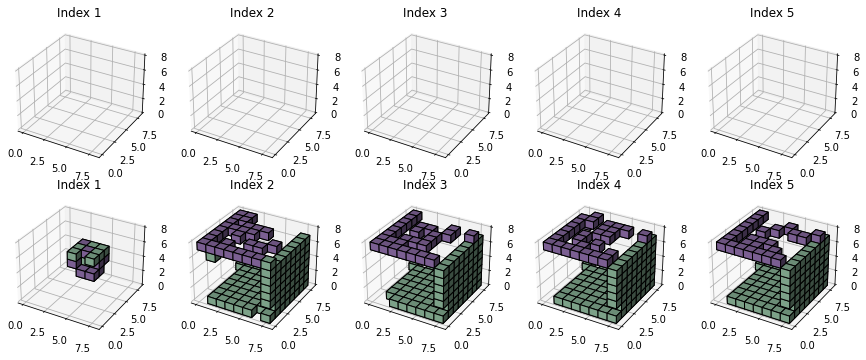

loss:3.449258804321289--iou_loss:0.9041095972061157:   0%|          | 3/20000 [00:03<6:52:26,  1.24s/it]  


KeyboardInterrupt: 

In [4]:
ct.train()

### View model weights

In [5]:
for name, W in ct.model.named_parameters():
    print(name, W)

perception_net.conv1.weight Parameter containing:
tensor([[[[[ 0.1334, -0.0857,  0.3110],
           [ 0.0074,  0.2080, -0.0431],
           [-0.0486, -0.1343, -0.1341]],

          [[ 0.1502,  0.3213, -0.1035],
           [-0.1860,  0.0543,  0.0955],
           [-0.1919, -0.1602,  0.0167]],

          [[ 0.0311, -0.1414,  0.1773],
           [ 0.1333, -0.0526, -0.0317],
           [-0.0076, -0.1892, -0.0256]]]],



        [[[[-0.1281,  0.0007, -0.1478],
           [-0.0370,  0.0130,  0.1531],
           [ 0.1288,  0.0095, -0.0519]],

          [[-0.0253, -0.0442, -0.0442],
           [ 0.1096,  0.0603, -0.1588],
           [ 0.0237,  0.0655, -0.1000]],

          [[-0.0321, -0.0363,  0.0799],
           [ 0.1296,  0.1385, -0.0684],
           [-0.0606,  0.0037,  0.0773]]]],



        [[[[ 0.1052, -0.0849,  0.0664],
           [ 0.1364,  0.0767, -0.1452],
           [-0.0392, -0.0409,  0.0075]],

          [[ 0.0380, -0.0454, -0.0031],
           [ 0.1368, -0.0242,  0.0666],
        

In [6]:
with torch.no_grad():
    for name, W in ct.model.named_parameters():
        W += torch.ones_like(W)

In [7]:
for name, W in ct.model.named_parameters():
    print(name, W)

perception_net.conv1.weight Parameter containing:
tensor([[[[[1.1334, 0.9143, 1.3110],
           [1.0074, 1.2080, 0.9569],
           [0.9514, 0.8657, 0.8659]],

          [[1.1502, 1.3213, 0.8965],
           [0.8140, 1.0543, 1.0955],
           [0.8081, 0.8398, 1.0167]],

          [[1.0311, 0.8586, 1.1773],
           [1.1333, 0.9474, 0.9683],
           [0.9924, 0.8108, 0.9744]]]],



        [[[[0.8719, 1.0007, 0.8522],
           [0.9630, 1.0130, 1.1531],
           [1.1288, 1.0095, 0.9481]],

          [[0.9747, 0.9558, 0.9558],
           [1.1096, 1.0603, 0.8412],
           [1.0237, 1.0655, 0.9000]],

          [[0.9679, 0.9637, 1.0799],
           [1.1296, 1.1385, 0.9316],
           [0.9394, 1.0037, 1.0773]]]],



        [[[[1.1052, 0.9151, 1.0664],
           [1.1364, 1.0767, 0.8548],
           [0.9608, 0.9591, 1.0075]],

          [[1.0380, 0.9546, 0.9969],
           [1.1368, 0.9758, 1.0666],
           [1.2000, 1.0942, 1.0995]],

          [[0.7847, 0.9973, 0.9716],
 

In [8]:
weights = ct.model.state_dict()

#### Save model

In [9]:
torch.save({"model":ct.model.state_dict()}, "test_model.pt")

#### Load Model

In [10]:
ct.load_model("test_model.pt", load_optimizer_and_scheduler = False)

### Create new trainer from pretrained model

In [11]:
ct = CustomMSETrainer.from_config(
                    "test_config.yaml",
                    config={
                        "pretrained_path":"test_model.pt",
                        "dataset_config":{"target_voxel":voxel, "target_unique_val_dict":target_unique_val_dict},
                        "use_cuda":False
                    }
                )

### Visualize output of NCA

In [12]:
from IPython.display import clear_output
from artefact_nca.utils.minecraft.voxel_utils import replace_colors

def visualize_output(ct, out):
    clear_output()
    out = rearrange(out, 'b d h w c -> b w d h c')
    argmax = np.argmax(out[:, :, :, :, :ct.num_categories], -1)
    out = replace_colors(argmax, ct.dataset.target_color_dict)[0]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(out, facecolors=out, edgecolor='k')
    
    plt.show()
    return argmax

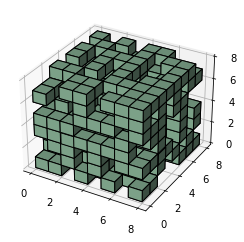

In [13]:
seed = np.ones(
            (1, 8, 8, 8, ct.num_channels)
        )
seed[:, :, :, :, 1:] = 10.0
seed = torch.from_numpy(seed).float().to(ct.device)

with torch.no_grad():
    final, states, life_masks = ct.rollout(steps=1, initial=seed)

_ = visualize_output(ct, final.cpu().numpy())

#### another step

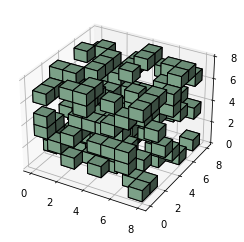

In [14]:
with torch.no_grad():
    final, states, life_masks = ct.rollout(steps=1, initial=final)

_ = visualize_output(ct, final.cpu().numpy())